In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV

In [3]:
from google.colab import drive
drive.mount('/content/drive')
file_path = "/content/drive/My Drive/classification_of_reviews/mustapp_reviews_total.csv"

data = pd.read_csv(file_path)

data = data.drop(['Mustapp page ID', 'Title', 'Description'], axis=1)
data = data.rename(columns={'Review text': 'Review', 'Score (out of 10)': 'Rating'})

Mounted at /content/drive


In [4]:
data['Sentiment'] = data['Rating'].apply(lambda x: 1 if x >= 7 else 0)

In [5]:
data

,Review,Rating,Sentiment
0,Фильм показывает нестабильную среду простых л...,8,1
1,Простые люди попадают в непростые обстоятельст...,8,1
2,В Финляндии более мрачные Патерсоны\n,7,1
3,Minimalistic with words but still full of mean...,8,1
4,"Просто, приземленно, обыденно, заурядно и имен...",8,1
...,...,...,...
177505,jodete ledinapoporu te quiero \n,8,1
177506,Todas las peliculas de doraemon son buenas lo ...,10,1
177507,"It's good, but could be better...\n",7,1
177508,Cute ‘95 chick flick. I love Whitney Houstonnn...,5,0


Отзыв будет считаться положительным, если его оценка неменьше 7-ми.

Для начала обучим логистическую регрессию на «грязных» данных, но сразу будем использовать tf-idf.

## 1. Logreg без очистки

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data[['Review']],
                                                    data['Sentiment'],
                                                    stratify=data['Sentiment'],
                                                    test_size=0.25,
                                                    random_state=42)

In [7]:
X_train.shape, X_test.shape

((133132, 1), (44378, 1))

In [8]:
raw_logreg = Pipeline([
    ('tf', TfidfVectorizer()),
    ('clf', LogisticRegression(random_state=42))
])

In [9]:
raw_logreg.fit(X_train['Review'], y_train)

Pipeline(steps=[('tf', TfidfVectorizer()),
                ('clf', LogisticRegression(random_state=42))])

In [10]:
pred = raw_logreg.predict(X_test['Review'])
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.72      0.27      0.39      9211
           1       0.84      0.97      0.90     35167

    accuracy                           0.83     44378
   macro avg       0.78      0.62      0.65     44378
weighted avg       0.81      0.83      0.79     44378



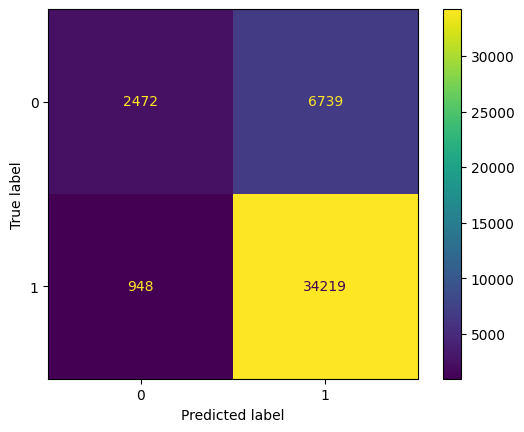

In [11]:
_ = ConfusionMatrixDisplay.from_estimator(raw_logreg, X_test['Review'], y_test)

## 2. Logreg с предобработкой (стеммер)

In [12]:
data_clean = data.copy()

In [13]:
def count_russian_chars(s: str) -> int:
    return len(re.findall(r'[а-яА-Я]', s))

data_clean['Russian chars'] = data_clean['Review'].apply(count_russian_chars)

In [14]:
data_clean_russian = data_clean[data_clean['Russian chars'] > 0]
data_clean_russian = data_clean_russian.reset_index(drop=True)

In [15]:
nltk.download('punkt')
nltk.download('punkt_tab')

stemmer = SnowballStemmer("russian")

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    words = word_tokenize(text, language="russian")
    words = [stemmer.stem(word) for word in words]
    return " ".join(words)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [16]:
data_clean_russian['Review'] = data_clean_russian['Review'].apply(lambda x: preprocess_text(str(x)))

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_clean_russian[['Review']],
                                                    data_clean_russian['Sentiment'],
                                                    stratify=data_clean_russian['Sentiment'],
                                                    test_size=0.25,
                                                    random_state=42)

In [18]:
pipeline = Pipeline([
    ('tf', TfidfVectorizer()),
    ('clf', LogisticRegression(random_state=42))
])

In [19]:
pipeline.fit(X_train['Review'], y_train)

Pipeline(steps=[('tf', TfidfVectorizer()),
                ('clf', LogisticRegression(random_state=42))])

In [20]:
pred = pipeline.predict(X_test['Review'])
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.70      0.33      0.44      6965
           1       0.84      0.96      0.90     25470

    accuracy                           0.82     32435
   macro avg       0.77      0.64      0.67     32435
weighted avg       0.81      0.82      0.80     32435



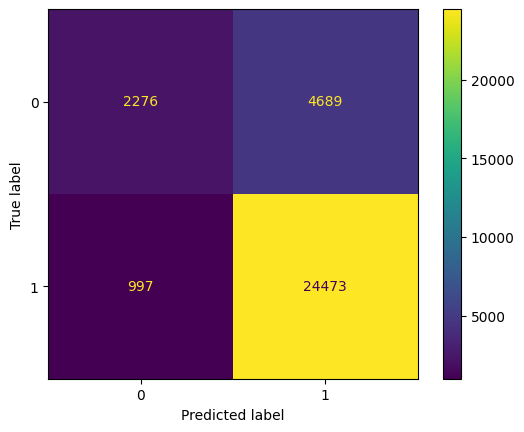

In [21]:
_ = ConfusionMatrixDisplay.from_estimator(pipeline, X_test['Review'], y_test)

## 3. Logreg с предобработкой (стеммер) и подбором гиперпараметров (для tf-idf тоже)

In [22]:
pipeline = Pipeline([
    ('tf', TfidfVectorizer()),
    ('clf', LogisticRegression(random_state=42))
])

param_grid = {
    'tf__ngram_range': [(1, 1), (1, 2)], # Важно посмотреть хотя бы на биграммах тоже
    'tf__max_features': [500, 1000, None],
    'clf__C': [0.1, 1, 10],
}

grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='precision', n_jobs=-1)

In [23]:
grid_search.fit(X_train['Review'], y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tf', TfidfVectorizer()),
                                       ('clf',
                                        LogisticRegression(random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__C': [0.1, 1, 10],
                         'tf__max_features': [500, 1000, None],
                         'tf__ngram_range': [(1, 1), (1, 2)]},
             scoring='precision')

In [24]:
print("Best parameters:", grid_search.best_params_)
best_clf = grid_search.best_estimator_

Best parameters: {'clf__C': 10, 'tf__max_features': None, 'tf__ngram_range': (1, 2)}


In [25]:
pred = best_clf.predict(X_test['Review'])
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.66      0.45      0.53      6965
           1       0.86      0.94      0.90     25470

    accuracy                           0.83     32435
   macro avg       0.76      0.69      0.72     32435
weighted avg       0.82      0.83      0.82     32435



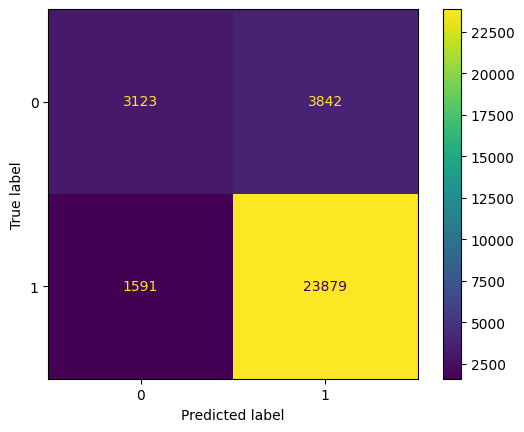

In [26]:
_ = ConfusionMatrixDisplay.from_estimator(best_clf, X_test['Review'], y_test)

## 4. Logreg с предобработкой (стеммер + стопслова)

In [27]:
data_clean = data.copy()

In [28]:
def count_russian_chars(s: str) -> int:
    return len(re.findall(r'[а-яА-Я]', s))

data_clean['Russian chars'] = data_clean['Review'].apply(count_russian_chars)

In [29]:
data_clean_russian = data_clean[data_clean['Russian chars'] > 0]
data_clean_russian = data_clean_russian.reset_index(drop=True)

In [30]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

stemmer = SnowballStemmer("russian")
stop_words = set(stopwords.words("russian"))

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    words = word_tokenize(text, language="russian")
    words = [stemmer.stem(word) for word in words if word not in stop_words]
    return " ".join(words)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [31]:
data_clean_russian['Review'] = data_clean_russian['Review'].apply(lambda x: preprocess_text(str(x)))

In [32]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_clean_russian[['Review']],
                                                    data_clean_russian['Sentiment'],
                                                    stratify=data_clean_russian['Sentiment'],
                                                    test_size=0.25,
                                                    random_state=42)

In [33]:
pipeline_2 = Pipeline([
    ('tf', TfidfVectorizer()),
    ('clf', LogisticRegression(random_state=42))
])

In [34]:
pipeline_2.fit(X_train['Review'], y_train)

Pipeline(steps=[('tf', TfidfVectorizer()),
                ('clf', LogisticRegression(random_state=42))])

In [35]:
pred = pipeline_2.predict(X_test['Review'])
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.70      0.31      0.43      6965
           1       0.84      0.96      0.90     25470

    accuracy                           0.82     32435
   macro avg       0.77      0.64      0.66     32435
weighted avg       0.81      0.82      0.80     32435



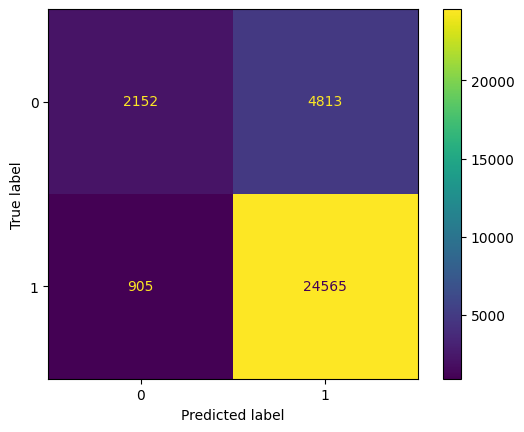

In [36]:
_ = ConfusionMatrixDisplay.from_estimator(pipeline_2, X_test['Review'], y_test)

## 5. Logreg с предобработкой (стеммер + стопслова) и подбором гиперпараметров (для tf-idf тоже)

In [37]:
pipeline = Pipeline([
    ('tf', TfidfVectorizer()),
    ('clf', LogisticRegression(random_state=42))
])

param_grid = {
    'tf__ngram_range': [(1, 1), (1, 2)], # Важно посмотреть хотя бы на биграммах тоже
    'tf__max_features': [500, 1000, None],
    'clf__C': [0.1, 1, 10],
}

grid_search_2 = GridSearchCV(pipeline, param_grid, cv=3, scoring='precision', n_jobs=-1)

In [38]:
grid_search_2.fit(X_train['Review'], y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tf', TfidfVectorizer()),
                                       ('clf',
                                        LogisticRegression(random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__C': [0.1, 1, 10],
                         'tf__max_features': [500, 1000, None],
                         'tf__ngram_range': [(1, 1), (1, 2)]},
             scoring='precision')

In [39]:
print("Best parameters:", grid_search_2.best_params_)
best_clf_2 = grid_search_2.best_estimator_

Best parameters: {'clf__C': 10, 'tf__max_features': None, 'tf__ngram_range': (1, 2)}


In [40]:
pred = best_clf_2.predict(X_test['Review'])
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.64      0.41      0.50      6965
           1       0.85      0.94      0.89     25470

    accuracy                           0.82     32435
   macro avg       0.75      0.67      0.70     32435
weighted avg       0.81      0.82      0.81     32435



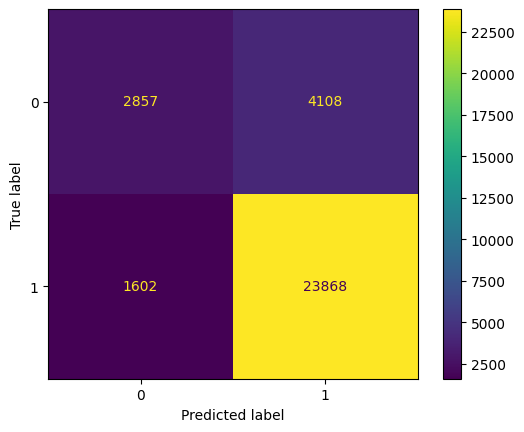

In [41]:
_ = ConfusionMatrixDisplay.from_estimator(best_clf_2, X_test['Review'], y_test)

# Вывод

## 1. Logreg без тюнинга
Базовая модель логистической регрессии без дополнительной предобработки текста и подбора гиперпараметров.
### Результаты:
*   Класс 0 (негативные): Precision=0.72, Recall=0.27, F1=0.39
*   Класс 1 (позитивные): Precision=0.84, Recall=0.97, F1=0.90
*   Accuracy: 0.83

Модель демонстрирует сильный дисбаланс в качестве классификации - при хороших показателях для позитивных отзывов (Recall=0.97) показывает крайне низкий Recall для негативных (0.27), что означает пропуск 73% негативных отзывов.

## 2. Logreg с предобработкой (стеммер)
Добавлена предобработка текста с использованием стемминга.
### Результаты:
*   Класс 0: Precision=0.70 (-0.02), Recall=0.33 (+0.06), F1=0.44 (+0.05)
*   Класс 1: Precision=0.84 (=), Recall=0.96 (-0.01), F1=0.90 (=)
*   Accuracy: 0.82 (-0.01)

Стемминг дал умеренное улучшение (+6%) Recall для негативных отзывов, но немного снизил общую точность. F1-score для негативного класса улучшился на 0.05.

## 3. Logreg с предобработкой (стеммер) и подбором гиперпараметров (для tf-idf тоже)
Добавлен подбор гиперпараметров для модели и TF-IDF.
### Результаты:
*   Класс 0: Precision=0.66 (-0.04), Recall=0.45 (+0.12), F1=0.53 (+0.09)
*   Класс 1: Precision=0.86 (+0.02), Recall=0.94 (-0.02), F1=0.90 (=)
*   Accuracy: 0.83 (+0.01)

Подбор параметров значительно улучшил Recall для негативных отзывов (+12% по сравнению с базовой моделью), хотя Precision для этого класса снизился. Общий F1-score для негативных отзывов вырос на 0.09.

## 4. Logreg с предобработкой (стеммер + стопслова)
Добавлено удаление стоп-слов к предобработке.
### Результаты:
*   Класс 0: Precision=0.70 (=), Recall=0.31 (-0.02), F1=0.43 (-0.01)
*   Класс 1: Precision=0.84 (=), Recall=0.96 (=), F1=0.90 (=)
*   Accuracy: 0.82 (=)

Удаление стоп-слов не дало положительного эффекта, а по некоторым метрикам даже ухудшило результаты по сравнению с использованием только стемминга.

## 5. Logreg с предобработкой (стеммер + стопслова) и подбором гиперпараметров (для tf-idf тоже)
Комбинация стемминга, удаления стоп-слов и подбора гиперпараметров.
### Результаты:
*   Класс 0: Precision=0.64 (-0.06), Recall=0.41 (+0.14), F1=0.50 (+0.07)
*   Класс 1: Precision=0.85 (+0.01), Recall=0.94 (-0.03), F1=0.89 (-0.01)
*   Accuracy: 0.82 (=)

Несмотря на подбор параметров, данная конфигурация не превзошла результаты эксперимента 3 (без стоп-слов), показав худшие значения Precision для негативного класса.

## Итог
### Лучшая конфигурация
Эксперимент 3 (стемминг + подбор гиперпараметров) показал наилучшие результаты:
*   Наибольший F1-score для негативных отзывов (0.53)
*   Оптимальный баланс между Recall (0.45) и Precision (0.66) для негативного класса
*   Стабильно высокие показатели для позитивного класса (F1=0.90)
*   Максимальная общая accuracy (0.83)

### Ключевые выводы:
1. Основная проблема - низкий Recall для негативных отзывов (максимум 0.45)
2. Подбор гиперпараметров дает наиболее значимый прирост качества
3. Удаление стоп-слов не улучшает качество классификации
4. Стемминг оказывает умеренное положительное влияние
